# Basics of Deep Learning Modelling

## Why Julia?

During this course, we will work with [Julia](https://julialang.org/) language. Why?

- It is a script language (just like Python or R)
- Julia is fast (almost like C)
- It has a strong [type system](https://upload.wikimedia.org/wikipedia/commons/d/d9/Julia-number-type-hierarchy.svg) 
- Build-in functions for distributed computing and GPU usage.
- Julia is easy to integrate with other languages (Python, R, C, …) 


Useful resources:

- [A good introductory course](https://juliaacademy.com/p/julia-programming-for-nervous-beginners)
- [Julia for Data Science](http://ucidatascienceinitiative.github.io/IntroToJulia/)
- [Think Julia](https://benlauwens.github.io/ThinkJulia.jl/latest/book.html)
- [Quantitative Economics lectures by Sargent and Stachursky](https://julia.quantecon.org/intro.html)
- [Other materials available at the language site - plenty of good resources and applications in different domains!](https://julialang.org/learning/)

### Useful Packages

####  1. DataFrames.jl

[<tt>DataFrames</tt>](https://dataframes.juliadata.org/stable/) is a package with resources for working with tabular data. It is an implementation of well-known data frames, with all the same tools as in the <tt>R</tt> or <tt>Pandas</tt> library in <tt>Python</tt>. If you want to learn more you could take a look at the [introduction to <tt>DataFrames</tt> ](https://github.com/bkamins/Julia-DataFrames-Tutorial).

#### 2. Plots.jl

[Plots](https://docs.juliaplots.org/latest/tutorial/) is a basic tool for plotting in Julia. The biggest advantage of this package is access to many different plotting [backends](http://docs.juliaplots.org/latest/backends/). Documentation of <tt>Plots.jl</tt> is avalaible [here](http://docs.juliaplots.org/latest/).


# Deep Learning Modelling

To build and train deep learning models we will use [flux.jl](http://fluxml.ai/) - Julia's machine learning stack:

- Flux is lightweight, written entirely in Julia; it is trivial to build case-specific models and modify the backbone of the package. 
- Flux supports all of Julia's syntax; the majority of Julia's functions and macros could be used in the models.
- Flux is easy and intuitive; building a basic model takes minutes at mos.


### Layers of Neural Network

Flux allows us to define the layers in many different ways:

In [1]:
@time using Flux

  8.385295 seconds (1.36 M allocations: 85.354 MiB, 0.97% gc time, 0.70% compilation time: 65% of which was recompilation)


In [2]:
W = rand(4, 8)
b = rand(4)
layer₁(x) = 1.0 ./ (1.0.+exp.(-W*x - b))

layer₁ (generic function with 1 method)

In [3]:
W

4×8 Matrix{Float64}:
 0.100797  0.96786   0.334992  0.515174  …  0.528579  0.0282103  0.36921
 0.124576  0.543668  0.374137  0.134839     0.122901  0.579848   0.305867
 0.404309  0.458234  0.265171  0.390798     0.485287  0.246886   0.630597
 0.757977  0.596531  0.328835  0.488066     0.786469  0.556841   0.30572

In [4]:
x = rand(8)
layer₁(x)

4-element Vector{Float64}:
 0.9320441106779055
 0.8977362613248412
 0.972484329778639
 0.9727317500372236

Naturally, the most popular [types of layers](https://fluxml.ai/Flux.jl/stable/reference/models/layers/) are already implemented, so we could just call them:

In [5]:
layer₂(x) = σ.(W * x .+ b)
layer₂(x)

4-element Vector{Float64}:
 0.9320441106779055
 0.8977362613248412
 0.972484329778639
 0.9727317500372236

In [6]:
layer₃ = Dense(8,4,σ)
layer₃(x)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(8 => 4, σ)    # 36 parameters
│   summary(x) = "8-element Vector{Float64}"
└ @ Flux C:\Users\barto\.julia\packages\Flux\htpCe\src\layers\stateless.jl:59


4-element Vector{Float32}:
 0.52527565
 0.4184397
 0.74049103
 0.6287538

We could also define layers on our own not only as simple matrices but also as structs, with more than one attribute: 

In [7]:
struct Poly
    W
    V
    b
end

Poly(in::Integer, out::Integer) =
  Poly((randn(out, in)),randn(out, in), (randn(out)))

# Overload call, so the object can be used as a function
(m::Poly)(x) = m.W * x.^2 + m.V*x .+ m.b

a = Poly(10, 5)

a(rand(10)) # => 5-element vector

5-element Vector{Float64}:
 -1.3638528283209808
 -3.300643548083036
  0.914523812712883
 -0.26617995099433023
  2.9092456374523143

To fully integrate a new layer with the Flux framework (e.g. to use gradient propagation or [GPU utilities](https://fluxml.ai/Flux.jl/stable/guide/gpu/)) we must additionally call <tt>@functor</tt> or [<tt>@layer</tt>](https://fluxml.ai/Flux.jl/stable/guide/models/basics/#Flux.@layer) macros:

In [8]:
Flux.@functor  Poly #or
Flux.@layer Poly  #or
Flux.@layer Poly trainable=(W,V)

In [9]:
using CUDA

has_cuda()

true

In [10]:
gpu(a)

Poly(Float32[0.7111163 0.39144233 … -0.8564464 -1.6014408; -1.0359623 -0.31550667 … -2.614731 1.1215798; … ; -0.40299112 -1.5584497 … 0.4851874 1.3041261; -0.09324045 -2.492568 … 1.3924967 -0.16233896], Float32[-0.27362195 -0.043326296 … -1.073093 -0.97338325; 1.4465222 -0.8967307 … -0.7891087 -0.9654518; … ; -0.013976358 -0.82173 … 0.50612503 0.3697614; -0.003047765 1.0386462 … 0.69312274 0.794068], Float32[0.43126947, 0.0829347, -0.9586144, -0.9476735, 1.554852])  # 100 parameters, plus 5 non-trainable

For a model with more than one layer, we must chain them together:

In [11]:
Layer₁ = Dense(28^2 => 32, relu)
Layer₂ = Dense(32 => 10)
Layer₃ = softmax

softmax (generic function with 3 methods)

We could use <tt>Chain</tt> function:

In [12]:
chain = Chain(x -> x^2, x-> -x)
m₁ = Chain(Layer₁ , Layer₂, Layer₃) 

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.617 KiB.

Moreover, a model could be defined as a function composition:

In [13]:
m₂(x) = Layer₃(Layer₂(Layer₁(x)))

m₂ (generic function with 1 method)

In [14]:
m₃(x) = Layer₁ ∘ Layer₂ ∘ Layer₃  

m₃ (generic function with 1 method)

or a pipeline:

In [15]:
m₄(x) = Layer₁(x) |> Layer₂  |> Layer₃ 

m₄ (generic function with 1 method)

### Cost Function; Regularization

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, chapter 7](http://www.deeplearningbook.org/contents/regularization.html)

In the previous lecture, we mentioned that neural network training is an indirect process; we must define a cost function $J(\theta)$, which will used to optimize the weights in the neural network.

In Flux, we could use any differentiable function as a cost function:

In [16]:
model = Dense(5,2)
x, y = rand(5), rand(2);
MSE(ŷ, y) = sum((ŷ.- y).^2)/ length(y)
loss(model,x,y) = MSE(model(x), y)
loss(model, x, y) 

0.7167516440735986

or use one of  [the pre-implemented ones](https://github.com/FluxML/Flux.jl/blob/8f73dc6e148eedd11463571a0a8215fd87e7e05b/src/layers/stateless.jl):

In [17]:
Flux.mse(model(x),y)

0.7167516440735986

During the training we want to achieve the lowest possible <b>generalization error</b>:

[![](https://cdn-images-1.medium.com/max/1600/1*1woqrqfRwmS1xXYHKPMUDw.png)](https://buzzrobot.com/bias-and-variance-11d8e1fee627)


However, neural networks tend to overfit easily, which might significantly reduce the quality of fit. To avoid such issues, we usually use one of plenty  <b>regularization</b> methods.


The most common regularization techniques are:

<b>Penalization of weights</b>:

One of the most common methods of regularization; adds penalty terms to the cost function to discourage complex models. It affects the weights of a neural network in the same way as the coefficients of a regression. The two most common penalties are:
- $\Omega(\theta) = ||\theta||_1 = \sum_i{|\theta_i|}$     (<i>LASSO</i>, <i>$L_1$ regularization</i>)
- $\Omega(\theta) = ||\theta||_2^2 = \sum_i{\theta_i^2}$ (<i>Tikhonov regularization</i>, <i>Ridge regression</i>, <i>$L_2$ regularization</i>).

[Implementation in Flux](https://fluxml.ai/Flux.jl/stable/guide/training/training/#Regularisation):

In [18]:
using LinearAlgebra

In [19]:
L₁(θ) = sum(abs, θ) 
L₂(θ) = sum(abs2, θ) 

L₂ (generic function with 1 method)

In [20]:
J(x,y,W) = loss(model,x ,y) + L₁(W)

J (generic function with 1 method)

In [21]:
J(x,y,W)

14.479723871966963

<b>Bagging (bootstrap aggregating)</b>:

From the initial dataset, $k$ sets are sampled uniformly with replacement. Then $k$  models are trained using the above bootstrap samples and combined by averaging the output (for regression) or voting (for classification).

<b>Dropout</b>:


In every iteration, neurons are removed from the model with a probability $p$. Binary mask vector $\mu = [1,1,0,1,1,1,\dots,0,1]$ represents the neurons used in the training process in $i$-th iteration. The goal of the training process is to minimize the value of $E_\mu[J(\theta,\mu)]$ for a given submodel induced by the mask $\mu$. Even though the expectation contains
exponentially manytermsm, with long enough training we obtain the unbiased estimator of a gradient of the expectation $E_\mu[J(\theta,\mu)]$ for each mask. Then, we use the full model for predictions, which closely approximates the ensemble learningproceduret,without thee costly process of generating and training $k$ separated models.

[Dropout is implemented as a model layer](https://fluxml.ai/Flux.jl/stable/reference/models/nnlib/#Dropout1): 

In [22]:
model = Chain(Dense(28^2 => 32, relu),
    Dropout(0.1),
Dense(32 => 10),
BatchNorm(64, relu),
softmax)

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dropout(0.1),
  Dense(32 => 10),                      # 330 parameters
  BatchNorm(64, relu),                  # 128 parameters, plus 128
  NNlib.softmax,
)         # Total: 6 trainable arrays, 25_578 parameters,
          # plus 2 non-trainable, 128 parameters, summarysize 100.859 KiB.

### Optimization

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, chapter 8](http://www.deeplearningbook.org/contents/optimization.html)

Choosing the proper optimization algorithm is an important step during neural network training. Cost function minimization is a non-trivial task; there are plenty of serious problems that might derail the learning process:

- ill-conditioned Hessian matrix.
- local minimas, plateaus, etc.
- vanishing and exploding gradients

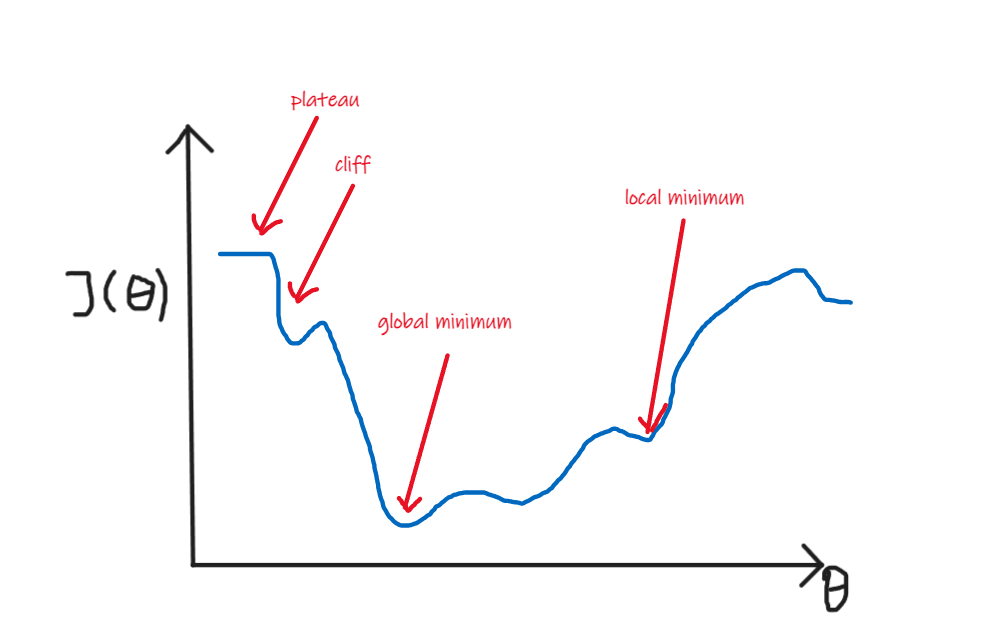

As a result, the vanilla stochastic gradient method might not be able to solve such problems. To overcome these issues, a plethora of SDG extensions were introduced. The most prominent ones are:

- SGD [(Robbins & Munro 1951)](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586)
- SGD with momentum [(Polyak, 1964)](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=zvmmf&paperid=7713&option_lang=eng)
- SGD with  Nesterov momentum ([Nesterov, 1983](http://www.cis.pku.edu.cn/faculty/vision/zlin/1983-A%20Method%20of%20Solving%20a%20Convex%20Programming%20Problem%20with%20Convergence%20Rate%20O%28k%5E%28-2%29%29_Nesterov.pdf), [2005](https://www.math.ucdavis.edu/~sqma/MAT258A_Files/Nesterov-2005.pdf))
- AdaGrad (Adaptive Gradient Algorithm) [(Duchi et. al. 2011)](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
- RMSProp [(Tieleman and Hinton 2012)](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
- ADAM (Adaptive Moment Estimation) [(Kingma & Ba, 2015)](https://arxiv.org/abs/1412.6980)

With Flux it is possible to  [compute a gradient of every function](https://fluxml.ai/Flux.jl/stable/guide/models/basics/)

In [23]:
f(x) = 3x^2 + 2x + 1

# df/dx = 6x + 2
df(x) = gradient(f, x)[1]

println(df(2)) # 14.0 

# d²f/dx² = 6
d²f(x) = gradient(df, x)[1]

println(d²f(2)) # 6.0 

14.0
6.0


It is even possible for functions that are not explicitly written down as a mathematical equation:  

In [24]:
function pow(x, n)
    r = 1
    for i = 1:n
        r *= x
    end
    return r
end

pow (generic function with 1 method)

In [25]:
pow(2,4)

16

In [26]:
gradient(x -> pow(x, 3), 5)

(75.0,)

In [27]:
pow2(x, n) = n <= 0 ? 1 : x*pow2(x, n-1)

pow2 (generic function with 1 method)

In [28]:
gradient(x -> pow2(x, 3), 5)

(75.0,)

[<tt>Zygote.jl</tt>](https://fluxml.ai/Zygote.jl/stable/) is a package that offers the efficient differentiation tools in Julia. Zygote is fully integrated with Julia, it uses the characteristic elements of the language, (e.g. its compiler) to get gradients of any function - including ones from the existing packages.

A brief explanation of how <tt>Zygote</tt> works is avalaible [here](https://github.com/MikeInnes/diff-zoo) and [here](https://arxiv.org/pdf/1810.07951.pdf).

### Automatic Differentiation

Gradient computation is non-trivial; Taking gradients via naïve numerical approximation:
$$f^{\prime}(a) \approx  \dfrac{f(a+h)-f(a)}{h} $$
is a poor choice, because of the inherent [numerical error](https://www.uio.no/studier/emner/matnat/math/MAT-INF1100/h10/kompendiet/kap11.pdf). There are many alternative methods of gradient approximation that significantly reduce the numerical error and improve the results. However, **automatic differentiation** is the most efficient way of taking gradients on a computer. 

Every computer function, even the most complicated one, is represented by a chain of basic functions (sin, cos, log, etc.). and elementary arithmetic operations (addition, subtraction, multiplication, division, etc.). By hardwiring the list with derivatives of basic functions and applying the chain rule of partial derivatives

$$
\frac{dy}{dx} = \frac{dy_1}{dx}*\frac{dy_2}{dy_1}*\dots*\frac{dy_{n-1}}{dy_{n-2}}*\frac{dy}{dy_{n-1}}
$$

to our objective function, we can efficiently differenciate it with minimal numerical error.

There are two modes of automatic differentiation:

- <b>forward</b> (or **bottom-up**):
  - start with known value of $\frac{dy_0}{dx} = \frac{dx}{dx} = 1$ 
  - compute a value of  $\frac{dy_1}{dx} = \frac{dy_0}{dx} * \frac{dy_1}{dy_0}$
  - repeat for every $\frac{dy_{i}}{dx} = \frac{dy_0}{dx} * \ldots * \frac{dy_{i-1}}{dy_{i-2}} * \frac{dy_{i}}{dy_{i-1}}$ until you reach $\frac{dy}{dx} = \frac{dy_0}{dx} * \ldots * \frac{dy_{n-1}}{dy_{n-2}}*\frac{dy_n}{dy_{n-1}}$

- <b>reverse</b> (or **top-down**):
   - start with known value of  $\frac{dy}{dy_n} = \frac{dy}{dy} = 1$
   -  compute a value of $\frac{dy}{dy_{n-1}} = \frac{dy}{dy_n} *\frac{dy_n}{dy_{n-1}}$
   -  repeat for every $\frac{dy}{dy_i} = \frac{dy}{dy_n} *\ldots*\frac{dy_{i+2}}{dy_{i+1}} * \frac{dy_{i+1}}{dy_i}$ until you reach $\frac{dy}{dx} = \frac{dy}{dy_n}*\ldots * \frac{dy_2}{dy_1}*\frac{dy_1}{dx}$

## Zygote.jl

All interactions with <tt>Zygote</tt> are based on two crucial elements: <tt>@adjoint</tt> macro and <tt>pullback</tt> function. 

<tt>pullback</tt> function output two values, original function $y = f(x)$ and *pullback*, an expression $\mathcal{B}(\overline{y}) =  \overline{y}  \cdot \frac{dy}{dx}$, where $\overline{y} = \frac{dl}{dy}$ is a parameter defined for a given function $l$.  

In [29]:
using Zygote

In [30]:
y, back = Zygote.pullback(sin, π);

In [31]:
y

0.0

In [32]:
back(1)

(-1.0,)

In particular, when $l = y = f(x)$ and $\overline{y} = \frac{dy}{dl} = 1$, pullback is equal to the gradient of $f(x)$:  

In [33]:
gradient(sin,π) == back(1)

true

<tt>@adjoint</tt> macro allows us to define and modify gradients of any function. This value will later be treated as an elementary function during the automatic differentiation process. 

In [34]:
using Zygote: @adjoint

In [35]:
minus(a,b) = a - b

minus (generic function with 1 method)

In [36]:
gradient(minus,2,3)

(1.0, -1.0)

In [37]:
minus2(a,b) = a - b

minus2 (generic function with 1 method)

In [38]:
@adjoint minus2(a,b) = minus2(a,b), c̄ -> (nothing, -b^2)

In [39]:
gradient(minus2,2,3)

(nothing, -9.0)

 ## Model training

 
 We could use predefined  [optimization algorithms](https://fluxml.ai/Optimisers.jl/stable/) available in [Flux](https://fluxml.ai/Flux.jl/stable/reference/training/optimisers/): 

In [40]:
#opt = ADAM(0.0001) #old implicit style - Flux 0.13 and below

opt_state = Flux.setup(Adam(0.0001), model) #explicit style - Flux 0.14 and higher

(layers = ((weight = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (p = (), dims = (), active = (), rng = ()), (weight = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

We can control the learning process in two distinctive manners, either by manually taking gradients: 

or with a function <tt>train!</tt>:

However, Flux is capable of training a model for one epoch only. To train it for a longer time, we must schedule it manually - usually with <tt>for</tt> loop: 

## Example

In [42]:
using Flux, Statistics
using Base.Iterators: repeated
using MLDatasets: MNIST, convert2image
using Images

Firstly, we will download and prepare dataset:

In [43]:
#ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

In [44]:
train_set = MNIST(:train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

Example image:

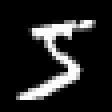

In [45]:
convert2image(MNIST,train_set.features)[:,:,1]

We will convert data into suitable format:

In [46]:
X = reshape(float.(train_set.features),size(train_set.features,1) * size(train_set.features,2),
    size(train_set.features,3))

784×60000 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [47]:
Y = Flux.onehotbatch(train_set.targets, 0:9) 

10×60000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Now, it is time for the test set:

In [48]:
test_set = MNIST(:test)

#reshape data
tX = reshape(float.(test_set.features),size(train_set.features,1) * size(train_set.features,2) ,
    size(test_set.features,3))

# One-hot-encode the labels
tY = Flux.onehotbatch(test_set.targets, 0:9);

We will divide data into minibatches:

In [49]:
batch_size = 256

loader = Flux.DataLoader((X, Y), batchsize=batch_size, shuffle=true);

Model definition:

In [50]:
m = Chain(
  Dense(28^2 => 32, relu),
  Dense(32 => 10),
  softmax) 

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.617 KiB.

We will use <b> binary cross-entropy </b> (<b>log-loss</b>) as a loss function:

$$ H_p(q) = - \sum_{i=1}^N {y_i log(p(y_i)) + (1 - y_i) log(p(1 -y_i))}$$

In [51]:
loss(m, x, y) = Flux.crossentropy(m(x), y)

accuracy(m, x, y) = mean(Flux.onecold(m(x)) .== Flux.onecold(y))

evalcb = () -> @show(loss(X, Y))
            
opt_state = Flux.setup(Adam(), m)

accuracy(m, X, Y)

0.08195

Training time!

In [52]:
 for epoch in 1:5
    Flux.train!(loss, m, loader, opt_state)
    @info "Epoch $epoch accuracy = $(accuracy(m, tX, tY))"
end

[ Info: Epoch 1 accuracy = 0.9091
[ Info: Epoch 2 accuracy = 0.924
[ Info: Epoch 3 accuracy = 0.934
[ Info: Epoch 4 accuracy = 0.9409
[ Info: Epoch 5 accuracy = 0.9445


We can save the results using the [<tt>BSON</tt>](https://github.com/JuliaIO/BSON.jl) package:

In [53]:
using BSON

In [54]:
s = Flux.state(m)
BSON.@save "MNIST.bson" s

and also load them:

In [55]:
m = Chain(
  Dense(28^2 => 32, relu),
  Dense(32 => 10),
  softmax) 

BSON.@load "MNIST.bson" s

Flux.loadmodel!(m, s)

accuracy(m, tX, tY)

0.9445

Alternatively, we can use Julia-native [JLD2](https://github.com/JuliaIO/JLD2.jl) format:

In [56]:
using JLD2

jldsave("MNIST.jld2"; model = Flux.state(m))

In [57]:
m = Chain(
  Dense(28^2 => 32, relu),
  Dense(32 => 10),
  softmax) 

s = JLD2.load("MNIST.jld2", "model")

Flux.loadmodel!(m, s)

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.617 KiB.

Finally, let us take a look at the accuracy of the model:

In [58]:
# Test set accuracy
accuracy(m, tX, tY)

0.9445

### Hyperparameter tuning

Only the weights $\theta$ are optimized during the training of a neural network. All the other parameters (activation functions, regularization methods, optimization algorithm, learning rate, etc.) are predefined by the user. We call them **hyperparameters**. To find the best model, it is necessary to find the best possible combination of hyperparameters. There are plenty of strategies that are useful in this process:
- using the examples from the literature
- randomly generating and comparing different combinations of hyperparameters
- searching the hyperparameters space with the proper algorithm 
- building a (meta)model able to [learn the best hyperparameters](https://arxiv.org/abs/2004.05439)

## Extra homework

1. Tune the hyperparameters of the multi-layer perceptron presented during the lecture. Try to find a network with an accuracy exceeding 95% <b>(7 points)</b>.
2. During the lecture we discuss dual numbers. Namely, numbers of the form: $z = a + \epsilon b$, where $a,b \in \mathbb{R}$ and  $\epsilon^2 = 0$. For every polynomial: $f(x) = a_0 + a_1x + a_2x^2 + \dots + a_nx^n$ a value for dual number $z$ is equal to: $f(z) = f(a) + bf'(a)\epsilon$. Show that it is indeed true <b>(3 points)</b>. 